In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats import proportion
import pingouin as pg
import os

%matplotlib inline

#### Импортируем данные

In [2]:
groups = pd.read_csv('groups.csv', sep=';')
active_studs = pd.read_csv('active_studs.csv')
checks = pd.read_csv('checks.csv', sep=';', names=['id', 'rev'], header=0)

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


FileNotFoundError: [Errno 2] No such file or directory: 'groups.csv'

#### Создаем функцию для автоматического импорта дополнительных данных<br>
Она проверяет, существует ли файл `groups_add.csv`, если да, то все метрики будут считаться с учетом новых данных. Заголовки столбцов заменяются на заголовки в `groups.csv`, чтобы привести все в единый вид. Новая и старая таблички смердживаются и добавляется индикатор того, что данные были добавлены позднее. Это нужно будет для построения графиков.

In [ ]:
def add_users(filename):
    if os.path.isfile(filename):
        groups_add = pd.read_csv(f'{filename}', names=['id', 'grp'], header=0)
        full_user_df = groups.merge(groups_add, how='outer', on=['id', 'grp'], indicator='date')
        full_user_df = full_user_df.replace({'left_only': 'initial', 'right_only': 'added'})
    else:
        full_user_df = groups
    return full_user_df

In [4]:
full_user_df = add_users('groups_add.csv')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


#### Небольшая предобработка и исследование:
- Заменяем названия групп на более понятные
- Добавляем столбец, говорящий об активности пользователя (ищем id в таблице `active_studs`)
- Проверяем типы данных в столбцах
- Проверяем id на предмет дубликатов

In [5]:
full_user_df = full_user_df.replace({'A': 'control', 'B': 'test'})

In [6]:
full_user_df['active'] = np.where(full_user_df.id.isin(active_studs.student_id), True, False) 

In [7]:
full_user_df.dtypes

id         int64
grp       object
date      object
active      bool
dtype: object

In [8]:
full_user_df.id.duplicated().sum()

0

Дополняем таблицу информацией о выручке для каждого пользователя и проверяем, есть ли покупатели среди неактивных во время проведения эксперимента

In [9]:
full_user_df = full_user_df.merge(checks, how='left', on='id').fillna(0)

In [10]:
full_user_df.query('active == False & rev > 0').grp.value_counts()

test       120
control     29
Name: grp, dtype: int64

***

Целевыми метриками будем считать **конверсию в покупателя** и конверсию активного пользователя в покупателя, прокси-метриками будут ARPPU (average revenue per paying user) [далее -- средний чек] и средний чек активного пользователя. Будем опираться на средний чек именно платящего пользователя из-за подавляющего количества не платящих пользователей, что сильно мешает анализу

Конверсия будет целевой метрикой, так как именно на нее оказывает прямое влияние механика оплаты услуг. Чем удобнее процесс оплаты, тем меньше вероятность того, что человек "отвалится" на этом этапе воронки, споткнувшись о сложности при оплате. <br>
На средний чек механика оплаты влияет не так сильно, но вполне может побудить пользователя добавить больше товаров в корзину перед оплатой, так что на ARPU тоже есть смысл посмотреть

Отдельно исследуем активных пользователей, данные о них будут более актуальными
***

### Конверсия в покупку

Добавляем столбец со статусом каждого юзера (сконвертировался или нет). Вычисляем это с помощью нулевой/ненулевой выручки с него

In [11]:
full_user_df['converted'] = full_user_df.rev.apply(lambda x: True if x > 0 else False)

#### Функция для расчета CR (чтобы не писать одну и ту же агрегацию для общего и для активных пользователей)
Считаем все id (так как нет дубликатов, можно использовать `count()`, суммируем всех сконвертировавшихся, и выводим конверсию

In [12]:
def get_cr_df(df):
    cr_df = df.groupby('grp', as_index=False) \
        .agg({'id': 'count', 'converted': 'sum'}) \
        .rename(columns={'id': 'total'}) 
    
    cr_df['cr'] = cr_df.converted / cr_df.total
    return cr_df

Невооруженным глазом заметно, что CR у контрольной и тестовой групп почти не отличаются в обоих случаях

In [13]:
cr_df_full = get_cr_df(full_user_df)
cr_df_full

,grp,total,converted,cr
0,control,14693,107,0.007282
1,test,59883,434,0.007247


In [14]:
cr_df_active = get_cr_df(full_user_df[full_user_df.active])
cr_df_active

,grp,total,converted,cr
0,control,1538,78,0.050715
1,test,6803,314,0.046156


Оптимальным тестом для наших целей (сравнения двух одиночных пропорций) считаю простой Z-тест для пропорции <br>
Его тоже заворачиваем в функцию, чтобы не писать несколько раз

In [15]:
def proportion_ztest(data1, data2):
    
    stat, p_val = proportion.proportions_ztest(
        count=[data1.converted, data2.converted],
        nobs=[data1.total, data2.total])
    
    print(f'Statistic: {stat[0]}, P-value: {p_val[0]}')

P-value и для всех пользователей, и для активных далек от 0.05, так что можно смело сделать **вывод**, 
что на конверсию в покупателя наш эксперимент статистически значимо **не повлиял**

In [16]:
proportion_ztest(cr_df_full[cr_df_full.grp == 'control'], cr_df_full[cr_df_full.grp == 'test'])

Statistic: 0.04468712655753046, P-value: 0.9643566949670365


In [17]:
proportion_ztest(cr_df_active[cr_df_active.grp == 'control'], cr_df_active[cr_df_active.grp == 'test'])

Statistic: 0.7629884495263746, P-value: 0.445470284371589


***
### Средний чек

Так же создаем функцию для рассчета среднего чека: группируем по группе, считаем всех покупателей (не обязательно здесь, но полезно знать) и среднюю выручку

In [18]:
def get_arppu(df):
    arppu_df = df[df.rev > 0] \
        .groupby('grp', as_index=False) \
        .agg({'id': 'count', 'rev': 'mean'}) \
        .rename(columns={'id': 'total', 'rev': 'arppu'})
    return arppu_df

Метрики и у всех и у активных пользователей на первый взгляд тоже не сильно различаются, хотя у тестовой группы показатели выше

In [19]:
arppu_df_full = get_arppu(full_user_df)
arppu_df_full

,grp,total,arppu
0,control,107,860.710280
1,test,434,1108.824893


In [20]:
arppu_df_active = get_arppu(full_user_df[full_user_df.active])
arppu_df_active

,grp,total,arppu
0,control,78,933.589744
1,test,314,1257.878992


Создаем отдельные датафреймы для контрольной и тестовой групп, чтобы было удобнее работать с графиками

In [21]:
paid_control = full_user_df.query('grp == "control" & rev > 0')
paid_test = full_user_df.query('grp == "test" & rev > 0')

Для удобства создаем функцию для вывода графиков, в которую будем подставлять общую массу и активных пользователей. Далее все тесты тоже будем оборачивать в функции

In [22]:
def get_histplots(data1, data2, group):
    f, axs = plt.subplots(1, 2, figsize=(15, 7))

    plt.subplots_adjust(wspace=0.4) 

    sns.histplot(data1.rev, ax=axs[0])
    axs[0].set_title('Control', pad=10)
    axs[0].set_xlabel(f'Revenue for {group} paying users')

    sns.histplot(data2.rev, ax=axs[1])
    axs[1].set_title('Test', pad=10)
    axs[1].set_xlabel(f'Revenue for {group} paying users')
    
    print(f)

Посмотрим на все ненулевые покупки. В тестовой группе заметны более высокие значения, тогда как в контрольной большая часть покупок была <500. Распределения не похожи на нормальные, но для контроля проверим их тестом из pingouin

Figure(1080x504)


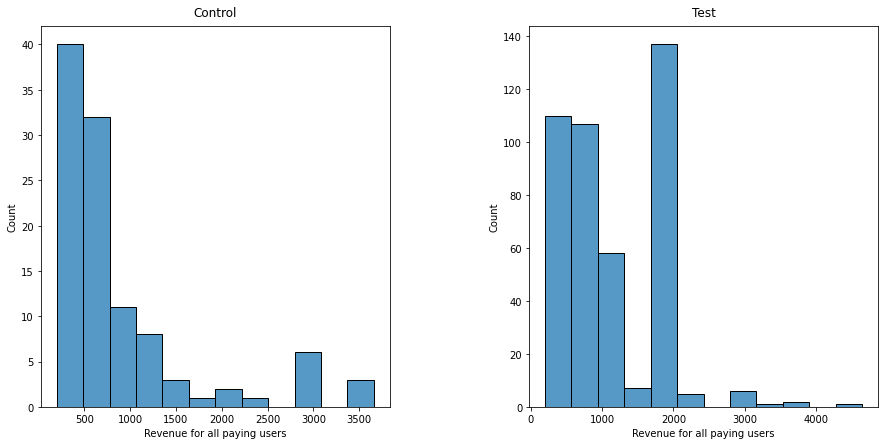

In [23]:
get_histplots(paid_control, paid_test, 'all')

Для активных юзеров картина очень похожая, хотя чуть более сглаженная

Figure(1080x504)


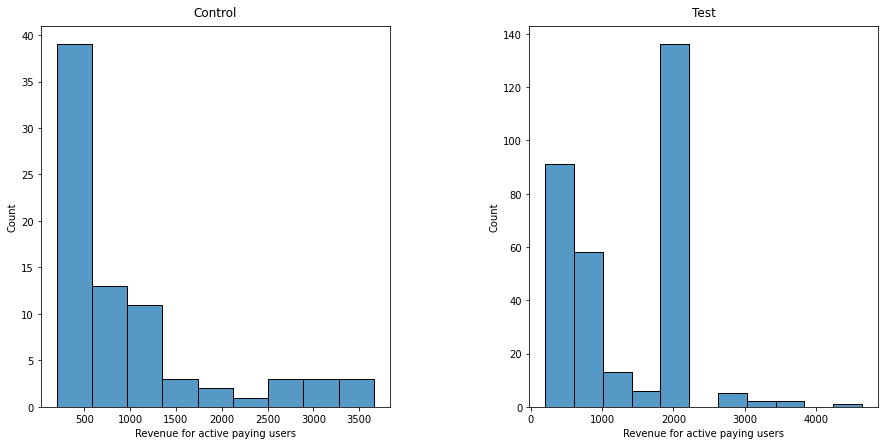

In [24]:
get_histplots(paid_control[paid_control.active], paid_test[paid_test.active], 'active')

Тест для активных и неактивных показывает, что распределения действительно не нормальные, так что в обоих случаях будем использовать непараметрический критерий Манна-Уитни и Бутстреп по среднему<br>
Ради интереса проверим различия Т-тестом, можно будет увидеть, соглашаются ли все три

In [25]:
def run_normality(data1, data2, group):
    print(f'Data for {group} paying users:')
    print(pg.normality(data1.rev))
    print(pg.normality(data2.rev))

In [26]:
run_normality(paid_control, paid_test, 'all')

Data for all paying users:
            W          pval  normal
rev  0.719612  5.321688e-13   False
            W          pval  normal
rev  0.867236  8.947893e-19   False


In [27]:
run_normality(paid_control[paid_control.active], paid_test[paid_test.active], 'active')

Data for active paying users:
            W          pval  normal
rev  0.735324  1.498682e-10   False
            W          pval  normal
rev  0.854724  1.543702e-16   False


И критерий Манна-Уитни, и Т-критерий показывают P-значение меньше 0.05, поэтому можем сделать предварительный вывод, что статистические различия все-таки есть

In [28]:
def run_mwu_and_ttest(data1, data2, group):
    print(f'Data for {group} paying users:')
    print(pg.mwu(data1.rev, data2.rev)['p-val'])
    print(pg.ttest(data1.rev, data2.rev)['p-val'])

In [29]:
run_mwu_and_ttest(paid_control, paid_test, 'all')

Data for all paying users:
MWU    0.000193
Name: p-val, dtype: float64
T-test    0.004732
Name: p-val, dtype: float64


In [30]:
run_mwu_and_ttest(paid_control[paid_control.active], paid_test[paid_test.active], 'active')

Data for active paying users:
MWU    0.000251
Name: p-val, dtype: float64
T-test    0.00507
Name: p-val, dtype: float64


Составим датафрейм с интервалами для медиан обоих метрик, чтобы они были наглядны и в одном месте

In [31]:
def get_intervals(data1, data2):

    d = {
        'higher': [
            stats.bootstrap((data1.rev, ), np.mean, method='basic').confidence_interval[1],
            stats.bootstrap((data2.rev, ), np.mean, method='basic').confidence_interval[1]
        ],
        'lower': [
            stats.bootstrap((data1.rev, ), np.mean, method='basic').confidence_interval[0],
            stats.bootstrap((data2.rev, ), np.mean, method='basic').confidence_interval[0]
        ]
    }

    intervals = pd.DataFrame(data=d, index=['control', 'test'])
    
    return intervals

Можно заметить не-пересечение интервалов для всех юзеров и пересечение для активных по таблице, но для контроля проведем быстрый тест с помощью pd.Interval и overlap

In [32]:
full_intervals = get_intervals(paid_control, paid_test)
full_intervals

,higher,lower
control,1009.064953,702.220093
test,1176.790561,1038.689639


In [33]:
active_intervals = get_intervals(paid_control[paid_control.active], paid_test[paid_test.active])
active_intervals

,higher,lower
control,1125.759615,722.266026
test,1344.685203,1170.157494


In [34]:
def check_intervals(data): 
    control_interval = pd.Interval(data.lower.loc['control'], data.higher.loc['control'])
    test_interval = pd.Interval(data.lower.loc['test'], data.higher.loc['test'])
    overlap = control_interval.overlaps(test_interval)
    print(overlap)

In [35]:
check_intervals(full_intervals)

False


In [36]:
check_intervals(active_intervals)

False


Можем подвести **итог**: статистически значимые различия в ARPPU между контрольной и тестовой группой выявлены в пользу тестовой группы. В случае ARPPAU статистических различий не выявлено, так как доверительный интервал контрольной группы полностью входит в интервал тестовой.

***
### Вывод
В ходе исследования выяснилось, что новая механика оплаты повлияла статистически значимо и положительно только на одну из четырех проверяемых метрик, так что запускать эту механику в продакшн не стоит. Но стоит заметить, что какое-то положительное влияние на средний чек имело место, возможно, стоит работать в эту сторону.

#### Примечание: <br>
При подгрузке доополнительного файла результаты исследования меняются: доверительные интервалы ARPPAU теперь не пересекаются. Все еще считаю, что эксперимент можно считать не успешным, так как изменения целевой метрики не были достигнуты

***

### Эпилог

После изначальной выгрузки данных поступил еще один файл с данными пользователей, здесь реализовываем функцию для построения графиков и сравнения изначальных значений рассматриваемых метрик с дополнительными

Функция проверяет, есть ли в нашем изначальном дф графа date (которая появляется только при загрузке дополнительного файла), и на основании этого строит барплоты либо для сравнения между контролем и тестом, либо между двумя датами выгрузки (и двумя группами теста)

In [37]:
def make_plots():
    
    f, axs = plt.subplots(2, 2, figsize=(15, 7))
    plt.subplots_adjust(wspace=0.4)
    
    cr_df = full_user_df.groupby(['date', 'grp', 'active'] 
                                 if 'date' in full_user_df.columns else ['grp', 'active'], as_index=False) \
        .agg({'id': 'count', 'converted': 'sum'}) 
    
    cr_df['cr'] = cr_df.converted / cr_df.id
    
    sns.barplot(data=cr_df, 
                x=cr_df.date if 'date' in cr_df.columns else cr_df.grp, 
                y=cr_df.cr,
                hue=cr_df.grp if os.path.isfile('groups_add.csv') else None,
                order=['initial', 'added'] if 'date' in cr_df.columns else None,
                ax=axs[0, 0]
                )
    
    sns.barplot(data=cr_df[cr_df.active],
                x=cr_df.date if 'date' in cr_df.columns else cr_df.grp, 
                y=cr_df.cr,
                hue=cr_df.grp if os.path.isfile('groups_add.csv') else None,
                order=['initial', 'added'] if 'date' in cr_df.columns else None,
                ax=axs[0, 1]
                )
    
    
    arppu_df = full_user_df[full_user_df.rev > 0] \
        .groupby(['date', 'grp', 'active'] 
                 if 'date' in full_user_df.columns else ['grp', 'active'], as_index=False) \
        .agg({'id': 'count', 'rev': 'mean'}) \
        .rename(columns={'rev': 'ARPU'})
    
    sns.barplot(data=arppu_df,
                x=arppu_df.date if 'date' in arppu_df.columns else arppu_df.grp, 
                y=arppu_df.ARPU,
                hue=arppu_df.grp,
                order=['initial', 'added'] if 'date' in arppu_df.columns else None,
                ax=axs[1, 0]
                )
    sns.barplot(data=arppu_df[arppu_df.active], 
                x=arppu_df.date if 'date' in arppu_df.columns else arppu_df.grp, 
                y=arppu_df.ARPU,
                hue=arppu_df.grp,
                order=['initial', 'added'] if 'date' in arppu_df.columns else None,
                ax=axs[1, 1]
                )
    print(f)

Figure(1080x504)


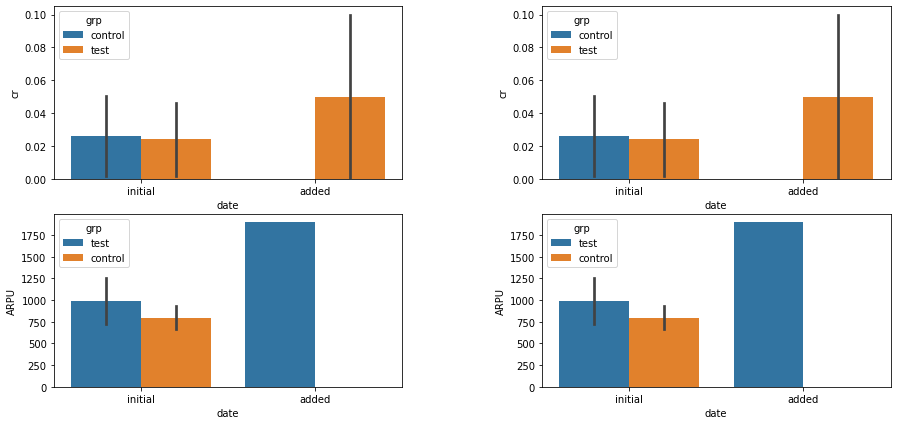

In [38]:
make_plots()